
# Udacity Self-Driving — Starter Notebook (Behavioral Cloning)
**What this notebook does (step-wise):**
1. Load `driving_log.csv` and images (center/left/right).  
2. Visualize sample rows & images.  
3. Preprocess images (crop, resize, normalize).  
4. Apply augmentations (flip, brightness, translation).  
5. Create a Python generator for efficient training.  
6. Build the NVIDIA CNN (end-to-end steering prediction).  
7. Train a baseline model (example config).  
8. Save the model for simulator / real-vehicle fine-tuning.

> **Files expected (already present):**
- `/mnt/data/driving_log.csv`  
- image files (e.g., `center_2025_08_27_23_00_47_235.jpg`, `left_*.jpg`, `right_*.jpg`) in `/mnt/data/`

**Notes:** This notebook is written so you can run it locally in a virtualenv. If TensorFlow / OpenCV are not installed in your environment, install them first (`pip install -r requirements.txt`).  


In [1]:

# Imports & configuration
import os
import math
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# The heavy libraries (cv2, tensorflow) are imported later inside functions so the notebook
# starts even if they are not installed. When you run training cells, make sure dependencies exist.

DATA_DIR = '.'
CSV_PATH = os.path.join(DATA_DIR, 'driving_log.csv')

print("Expected CSV path:", CSV_PATH)
print("Listing files in /mnt/data (showing up to 40):")
files = os.listdir(DATA_DIR)
for f in files[:40]:
    print(" -", f)


Expected CSV path: .\driving_log.csv
Listing files in /mnt/data (showing up to 40):
 - .ipynb_checkpoints
 - driving_log.csv
 - IMG
 - self_driving_starter.ipynb
 - SteeringAngle.ipynb


In [2]:

# 1) Load driving_log.csv safely (handles different delimiters)
import csv

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"Couldn't find driving_log.csv at {CSV_PATH}")

# Try typical separators automatically
sep = None
with open(CSV_PATH, 'r', encoding='utf-8', errors='ignore') as f:
    sample = f.read(2048)
    if '\t' in sample:
        sep='\t'
    elif ';' in sample and ',' not in sample:
        sep=';'
    else:
        sep=','

print("Detected CSV separator:", repr(sep))
df = pd.read_csv(CSV_PATH, sep=sep, header=None, engine='python', na_filter=False)

# If the CSV has header names, try to detect typical header pattern
# Udacity logs often have columns: center,left,right,steering,throttle,brake,speed
if df.shape[1] >= 7:
    # rename to common names
    df = df.iloc[:, :7]
    df.columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
else:
    # fallback
    df.columns = [f'col{i}' for i in range(df.shape[1])]

print("CSV shape:", df.shape)
df.head(5)


Detected CSV separator: ','
CSV shape: (1065, 7)


,center,left,right,steering,throttle,brake,speed
0,C:\Users\nages\Downloads\simulator-windows-64\...,C:\Users\nages\Downloads\simulator-windows-64...,C:\Users\nages\Downloads\simulator-windows-64...,0.0,0.0,0.0,0.000112
1,C:\Users\nages\Downloads\simulator-windows-64\...,C:\Users\nages\Downloads\simulator-windows-64...,C:\Users\nages\Downloads\simulator-windows-64...,0.0,0.0,0.0,0.000110
2,C:\Users\nages\Downloads\simulator-windows-64\...,C:\Users\nages\Downloads\simulator-windows-64...,C:\Users\nages\Downloads\simulator-windows-64...,0.0,0.0,0.0,0.000038
3,C:\Users\nages\Downloads\simulator-windows-64\...,C:\Users\nages\Downloads\simulator-windows-64...,C:\Users\nages\Downloads\simulator-windows-64...,0.0,0.0,0.0,0.000056
4,C:\Users\nages\Downloads\simulator-windows-64\...,C:\Users\nages\Downloads\simulator-windows-64...,C:\Users\nages\Downloads\simulator-windows-64...,0.0,0.0,0.0,0.000097


In [5]:
# Path where images are stored
IMG_DIR = "./IMG"   # update if your images folder has a different name or path

# Helpers: normalize paths and show samples
def img_path_from_csv(path):
    # CSV might store full path or just filename. Use basename and join with IMG_DIR
    base = os.path.basename(str(path).strip())
    return os.path.join(IMG_DIR, base)

# Add absolute paths columns
for col in ['center','left','right']:
    if col in df.columns:
        df[col] = df[col].apply(img_path_from_csv)

# Show sample row counts and example
print("Total rows:", len(df))
display(df.head(6))


Total rows: 1065


,center,left,right,steering,throttle,brake,speed
0,./IMG\center_2025_08_27_22_59_38_248.jpg,./IMG\left_2025_08_27_22_59_38_248.jpg,./IMG\right_2025_08_27_22_59_38_248.jpg,0.0,0.0,0.0,0.000112
1,./IMG\center_2025_08_27_22_59_38_346.jpg,./IMG\left_2025_08_27_22_59_38_346.jpg,./IMG\right_2025_08_27_22_59_38_346.jpg,0.0,0.0,0.0,0.000110
2,./IMG\center_2025_08_27_22_59_38_447.jpg,./IMG\left_2025_08_27_22_59_38_447.jpg,./IMG\right_2025_08_27_22_59_38_447.jpg,0.0,0.0,0.0,0.000038
3,./IMG\center_2025_08_27_22_59_38_547.jpg,./IMG\left_2025_08_27_22_59_38_547.jpg,./IMG\right_2025_08_27_22_59_38_547.jpg,0.0,0.0,0.0,0.000056
4,./IMG\center_2025_08_27_22_59_38_650.jpg,./IMG\left_2025_08_27_22_59_38_650.jpg,./IMG\right_2025_08_27_22_59_38_650.jpg,0.0,0.0,0.0,0.000097
5,./IMG\center_2025_08_27_22_59_38_750.jpg,./IMG\left_2025_08_27_22_59_38_750.jpg,./IMG\right_2025_08_27_22_59_38_750.jpg,0.0,0.0,0.0,0.000039


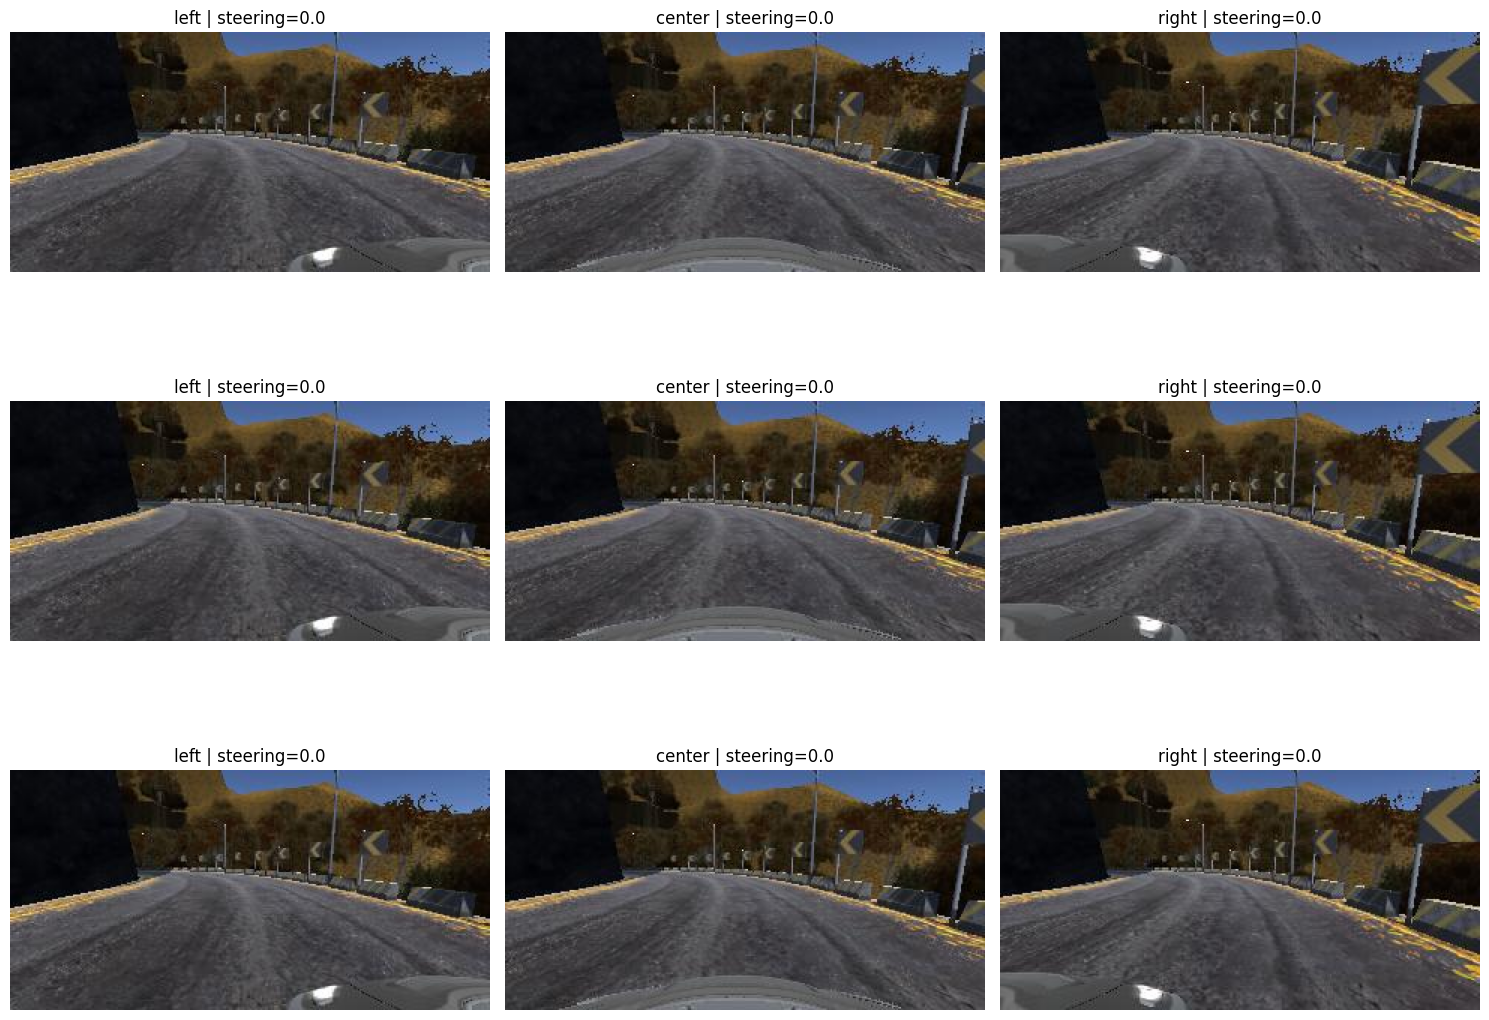

In [6]:

# Visualize some sample images (center, left, right)
import cv2
def show_image(path, ax=None, title=None):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if ax is None:
        plt.figure(figsize=(8,3))
        plt.imshow(img); plt.axis('off')
        if title: plt.title(title)
    else:
        ax.imshow(img); ax.axis('off')
        if title: ax.set_title(title)

# Display first N samples
N = min(3, len(df))
plt.figure(figsize=(15, 4*N))
for i in range(N):
    row = df.iloc[i]
    ax = plt.subplot(N, 3, i*3 + 1)
    try:
        show_image(row['left'], ax=ax, title=f"left | steering={row.get('steering','?')}")
    except Exception as e:
        ax.text(0.5,0.5,str(e)); ax.axis('off')
    ax = plt.subplot(N, 3, i*3 + 2)
    try:
        show_image(row['center'], ax=ax, title=f"center | steering={row.get('steering','?')}")
    except Exception as e:
        ax.text(0.5,0.5,str(e)); ax.axis('off')
    ax = plt.subplot(N, 3, i*3 + 3)
    try:
        show_image(row['right'], ax=ax, title=f"right | steering={row.get('steering','?')}")
    except Exception as e:
        ax.text(0.5,0.5,str(e)); ax.axis('off')
plt.tight_layout()


In [7]:

# Preprocessing: crop, resize, normalize
# We'll use the Nvidia input size: 66 x 200 (HxW)
def preprocess_image(cv2_img, resize=(200,66)):
    # cv2_img: color image in BGR (as returned by cv2.imread)
    import cv2
    # convert to RGB
    img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    # crop: remove sky and hood roughly (tweak based on images)
    top = int(h*0.35)   # remove top 35%
    bottom = int(h*0.1) # remove bottom 10%
    img = img[top:h-bottom, :, :]
    # resize (width, height)
    img = cv2.resize(img, resize, interpolation=cv2.INTER_AREA)
    # normalize to range [-0.5, 0.5]
    img = img.astype('float32') / 255.0 - 0.5
    return img

# Quick test (only if cv2 is present)
try:
    import cv2
    sample_img = cv2.imread(df['center'].iloc[0])
    if sample_img is not None:
        pre = preprocess_image(sample_img)
        print("Preprocessed image shape:", pre.shape, "min/max:", pre.min(), pre.max())
    else:
        print("Couldn't read sample image for preprocessing test.")
except Exception as e:
    print("cv2 not available or preprocess test failed:", e)


Preprocessed image shape: (66, 200, 3) min/max: -0.5 0.4137255


In [8]:

# Augmentation helpers: flip, brightness, translate
import numpy as np
import random

def random_flip(image, steering):
    # image: RGB float image (preprocessed or raw)
    if random.random() < 0.5:
        image = np.fliplr(image)
        steering = -steering
    return image, steering

def random_brightness(image):
    # expects image in 0..1 or -0.5..0.5; convert to 0..1 first
    img = image + 0.5
    hsv = cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_RGB2HSV)
    factor = 0.4 + np.random.uniform()
    hsv[:,:,2] = np.clip(hsv[:,:,2].astype(float) * factor, 0, 255).astype('uint8')
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB).astype('float32') / 255.0 - 0.5
    return img

def random_translate(image, steering, range_x=50, range_y=10):
    # translate image and adjust steering slightly
    rows, cols = image.shape[:2]
    tr_x = range_x * (np.random.uniform() - 0.5)
    tr_y = range_y * (np.random.uniform() - 0.5)
    M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    import cv2
    trans = cv2.warpAffine((image+0.5)*255.0, M, (cols, rows))
    trans = trans.astype('uint8')
    trans = cv2.cvtColor(trans, cv2.COLOR_BGR2RGB).astype('float32')/255.0 - 0.5
    steering += tr_x * 0.002  # tuning factor
    return trans, steering


In [9]:

# Generator: yields batches (memory efficient)
import math
def generator(samples, batch_size=32, is_training=True, correction=0.2):
    num_samples = len(samples)
    import cv2
    while True:
        samples = samples.sample(frac=1).reset_index(drop=True) if is_training else samples
        images = []
        steerings = []
        for offset in range(0, num_samples):
            row = samples.iloc[offset]
            # pick center/left/right with equal chance (during training)
            if is_training:
                choice = random.choice(['center','left','right'])
            else:
                choice = 'center'
            img_path = row[choice]
            steering = float(row.get('steering', 0.0))
            # adjust for left/right
            if choice == 'left':
                steering += correction
            elif choice == 'right':
                steering -= correction
            # read image
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = preprocess_image(img)  # result in range [-0.5,0.5]
            if is_training:
                # augment
                img, steering = random_flip(img, steering)
                img = random_brightness(img)
                img, steering = random_translate(img, steering)
            images.append(img)
            steerings.append(steering)
            # yield batch
            if len(images) >= batch_size:
                X = np.array(images)
                y = np.array(steerings)
                yield X, y
                images = []
                steerings = []
        # yield remaining if any
        if len(images) > 0:
            X = np.array(images)
            y = np.array(steerings)
            yield X, y


In [10]:

# Build NVIDIA model
def build_nvidia_model(input_shape=(66,200,3)):
    try:
        import tensorflow as tf
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Lambda, Cropping2D
        from tensorflow.keras.layers import Activation, MaxPooling2D
    except Exception as e:
        raise ImportError("TensorFlow is required to build the model. Install tensorflow and rerun. Error: " + str(e))

    model = Sequential()
    # Normalization already done in preprocess, but keep a lambda just in case
    model.add(Lambda(lambda x: x, input_shape=input_shape))
    # NVIDIA architecture
    model.add(Conv2D(24, (5,5), strides=(2,2), activation='relu'))
    model.add(Conv2D(36, (5,5), strides=(2,2), activation='relu'))
    model.add(Conv2D(48, (5,5), strides=(2,2), activation='relu'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    return model

# Quick model summary test (will require TensorFlow)
try:
    m = build_nvidia_model()
    m.summary()
except Exception as e:
    print("Model summary skipped (TensorFlow missing or error):", e)


C:\Users\nages\AutonomousEV\venv\lib\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 66, 200, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 31, 98, 24)          │           1,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 47, 36)          │          21,636 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 5, 22, 48)           │          43,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 20, 64)           │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1, 18, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         115,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,219 (985.23 KB)

 Trainable params: 252,219 (985.23 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:

# Train / Validation split and example training call
from sklearn.model_selection import train_test_split

# If steering column missing, create zero steering (fallback)
if 'steering' not in df.columns:
    df['steering'] = 0.0

train_samples, validation_samples = train_test_split(df, test_size=0.2, random_state=42)
print("Train samples:", len(train_samples), "Validation samples:", len(validation_samples))

# Training config (adjust as per your hardware)
BATCH_SIZE = 32
EPOCHS = 3
train_gen = generator(train_samples, batch_size=BATCH_SIZE, is_training=True)
valid_gen = generator(validation_samples, batch_size=BATCH_SIZE, is_training=False)

# Fit model example (will run only if tensorflow is installed)
try:
    import tensorflow as tf
    model = build_nvidia_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')
    steps_per_epoch = max(1, len(train_samples)//BATCH_SIZE)
    validation_steps = max(1, len(validation_samples)//BATCH_SIZE)
    print("Starting a quick training run (this may be slow). Steps per epoch:", steps_per_epoch)
    history = model.fit(train_gen,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=valid_gen,
                        validation_steps=validation_steps,
                        epochs=EPOCHS,
                        verbose=1)
    # Save model
    model_path = os.path.join(DATA_DIR, 'model.h5')
    model.save(model_path)
    print("Saved model to:", model_path)
except Exception as e:
    print("Training skipped (TensorFlow not available or other error):", e)
    print("When you run this cell locally with TF installed, the model will train and save to /mnt/data/model.h5")


Train samples: 852 Validation samples: 213
Starting a quick training run (this may be slow). Steps per epoch: 26
Epoch 1/3
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 718ms/step - loss: 0.0810 - val_loss: 0.0476
Epoch 2/3
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 426ms/step - loss: 0.0808 - val_loss: 0.0475
Epoch 3/3
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 356ms/step - loss: 0.0802 - val_loss: 0.0439


Saved model to: .\model.h5



## How to run this notebook locally (step-by-step)

1. Create & activate your virtual environment:
- **Linux / Mac**
```bash
python3 -m venv venv
source venv/bin/activate
```
- **Windows (PowerShell)**
```powershell
python -m venv venv


env\Scripts\Activate.ps1
```

2. Install requirements:
```bash
pip install -r /mnt/data/requirements.txt
```

3. Start Jupyter and open the notebook:
```bash
jupyter notebook /mnt/data/self_driving_starter.ipynb
```

4. Run cells top-to-bottom.

